In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

from astropy.time import Time
from astropy.visualization import quantity_support
import astropy.units as u
quantity_support()

import specutils
specutils.conf.do_continuum_function_check = False
%load_ext autoreload
%autoreload 2

import padre_meddea
from padre_meddea.io.file_tools import read_file
from padre_meddea.util import util as util
import padre_meddea.spectrum.calibration as cal

from specutils import Spectrum1D

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


c:\Users\sdchris1\AppData\Local\miniforge3\envs\padre_meddea\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
padre_meddea.__version__

'0.1.dev67+g422145b'

In [3]:
str(Time.now())

'2025-07-14 14:10:36.458477'

This notebook demonstrates the fast energy calibration tools that are provided in padre_meddea for event list (or photon data). This calibration is specific to a Ba-133 spectrum which is the calibration source on board Meddea.  The main calibration function is cal.The calibration steps are
* determine a rough calibration function by finding the two strongest lines (cal.get_calfunc_barium_rough)
* estimate the location of the rest of the barium lines and fit the precise location of peaks of those lines (cal.fit_peaks)
* determine the linear transformation between adc channel and energy
  

In [4]:
ba_spec_file = Path("padre_meddea_l0test_spectrum_20250130T104648_v0.1.0.fits")
am_spec_file = Path("padre_meddea_l0test_spectrum_20250130T121750_v0.1.0.fits")
ba_hk_file = Path("padre_meddea_l0test_housekeeping_20250130T104656_v0.1.0.fits")
am_hk_file = Path("padre_meddea_l0test_housekeeping_20250130T121800_v0.1.0.fits")

In [5]:
from astropy.io import fits
h = fits.open(ba_hk_file)
h['READ'].data

FITS_rec([([ 2.46070600e+06, -5.07474785e-02],   791549220,     8357103,      0,     17,    363, 'mode'),
          ([ 2.46070600e+06, -5.07474595e-02],   791549220,     8389995,   1280,  22993,    364, 'commit_hash_least'),
          ([ 2.46070600e+06, -5.07474395e-02],   791549220,     8424615,   1282,   2011,    365, 'commit_hash_most'),
          ([ 2.46070600e+06, -5.07474194e-02],   791549220,     8459235,   1284,  36929,    366, 'user_hash_least'),
          ([ 2.46070600e+06, -5.07473994e-02],   791549220,     8493855,   1286,   8984,    367, 'user_hash_most'),
          ([ 2.46070600e+06, -5.07473794e-02],   791549220,     8528475,   1288,  40989,    368, 'build_time_least'),
          ([ 2.46070600e+06, -5.07473593e-02],   791549220,     8563095,   1290,  26522,    369, 'build_time_most')],
         dtype=(numpy.record, [('time', '>f8', (2,)), ('pkttimes', '>i4'), ('pktclock', '>i4'), ('address', '>i2'), ('value', '>i2'), ('seqcount', '>i2'), ('name', 'S17')]))

# Barium-133 Spectrum Data

In [6]:
spec_list = read_file(ba_spec_file)

In [7]:
spec_list

SpectrumList (438 spectra, 7,753,196 events)
2025-01-30 10:46:48.183 - 11:59:38.183 (1hr 12min 50.0s)
<Spectrum1D(flux=[[[0.9828355312500001 ... 0.0]]] ct (shape=(438, 24, 512), mean=1.44054 ct); spectral_axis=<SpectralAxis [  0.   1.   2. ... 509. 510. 511.] pix> (length=512))>

In [8]:
spec_list.specs[0]

<Spectrum1D(flux=[[0.9828355312500001 ... 0.0]] ct (shape=(24, 512), mean=1.29938 ct); spectral_axis=<SpectralAxis [  0.   1.   2. ... 509. 510. 511.] pix> (length=512))>

In [9]:
spec_list.specs.spectral_axis

<SpectralAxis [  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
    12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,
    24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,  35.,
    36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,
    48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,
    60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,  70.,  71.,
    72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.,  80.,  81.,  82.,  83.,
    84.,  85.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,
    96.,  97.,  98.,  99., 100., 101., 102., 103., 104., 105., 106., 107.,
   108., 109., 110., 111., 112., 113., 114., 115., 116., 117., 118., 119.,
   120., 121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
   132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142., 143.,
   144., 145., 146., 147., 148., 149., 150., 151., 152., 153., 154., 155.,
   156., 157.

In [10]:
hk_ts, cmd_ts = read_file(ba_hk_file)

In [11]:
hk_ts

time,timestamp,fp_temp,dib_temp,hvps_temp,hvps_vsense,hvps_csense,csense_15v,csense_33vd,csense_33va,hit_rate,good_cmd_cnt,error_cnt,heater_pwm_duty_cycle,decimation_rate,error_summary,seqcount
Time,uint32,uint16,uint16,uint16,uint16,uint16,uint16,uint16,uint16,uint16,uint16,uint16,uint16,uint16,uint16,uint16
2025-01-30 10:46:56.000,791549221,35488,28704,17963,29735,7287,28328,35073,36209,3181,979,0,2151,65325,111,1651
2025-01-30 10:47:01.000,791549226,35488,28704,17956,29732,6885,28314,35072,36229,3258,979,0,2151,65325,111,1652
2025-01-30 10:47:06.000,791549231,35488,28701,17942,29731,7001,28310,34906,36201,3103,979,0,2151,65325,111,1653
2025-01-30 10:47:11.000,791549236,35488,28699,17939,29732,7169,28159,35012,36233,3134,979,0,2151,65325,111,1654
2025-01-30 10:47:16.000,791549241,35488,28694,17934,29735,6867,28316,34902,36228,3307,979,0,2151,65325,111,1655
2025-01-30 10:47:21.000,791549246,35488,28693,17931,29733,6836,28309,34998,36232,3271,979,0,2151,65325,111,1656
2025-01-30 10:47:26.000,791549251,35488,28689,17918,29737,6945,28313,35086,36223,3166,979,0,2151,65325,111,1657
2025-01-30 10:47:31.000,791549256,35488,28688,17911,29735,6739,28308,34897,36233,3176,979,0,2151,65325,111,1658
2025-01-30 10:47:36.000,791549261,35488,28688,17909,29734,6727,28307,34993,36211,3198,979,0,2151,65325,111,1659


In [12]:
cmd_ts

time,pkttimes,pktclock,address,value,seqcount,name
Time,uint32,uint32,uint16,uint16,uint16,bytes17
2025-01-30 10:46:55.418,791549220,8357103,0,17,363,mode
2025-01-30 10:46:55.419,791549220,8389995,1280,22993,364,commit_hash_least
2025-01-30 10:46:55.421,791549220,8424615,1282,2011,365,commit_hash_most
2025-01-30 10:46:55.423,791549220,8459235,1284,36929,366,user_hash_least
2025-01-30 10:46:55.425,791549220,8493855,1286,8984,367,user_hash_most
2025-01-30 10:46:55.426,791549220,8528475,1288,40989,368,build_time_least
2025-01-30 10:46:55.428,791549220,8563095,1290,26522,369,build_time_most


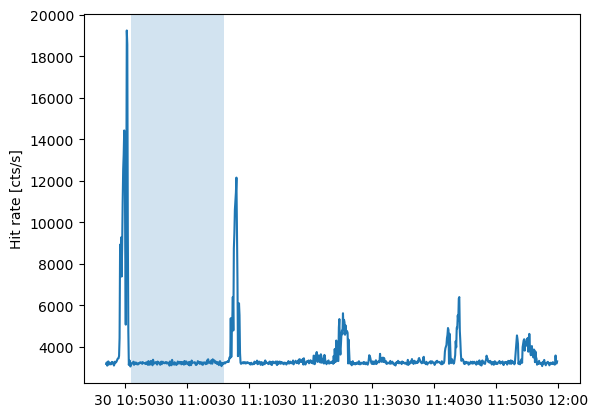

In [13]:
plt.plot(hk_ts.time.to_datetime(), hk_ts['hit_rate'])
plt.ylabel("Hit rate [cts/s]")
good_tr = [Time('2025-01-30T10:51'), Time('2025-01-30T11:06')]
plt.axvspan(good_tr[0].to_datetime(), good_tr[1].to_datetime(), alpha=0.2)

Times with increased hit rate is due to microphonics from the cooling system.

In [14]:
good_tr

[<Time object: scale='utc' format='isot' value=2025-01-30T10:51:00.000>,
 <Time object: scale='utc' format='isot' value=2025-01-30T11:06:00.000>]

In [15]:
spec_list = spec_list[good_tr[0] : good_tr[1]]

In [16]:
spec_list

SpectrumList (90 spectra, 1,451,903 events)
2025-01-30 10:51:08.183 - 11:05:58.183 (14min 50.0s)
<Spectrum1D(flux=[[[0.9835632625 ... 0.0]]] ct (shape=(90, 24, 512), mean=1.31285 ct); spectral_axis=<SpectralAxis [  0.   1.   2. ... 509. 510. 511.] pix> (length=512))>

In [17]:
spec_list.pixel_list

asic,pixel,channel,id,label
uint8,uint8,uint8,uint16,str12
0,0,26,51738,Det0Pixel0L
0,2,8,51720,Det0Pixel2L
0,5,18,51730,Det0Pixel5L
0,7,0,51712,Det0Pixel7L
0,9,21,51733,Det0Pixel9S
0,11,3,51715,Det0Pixel11S
1,0,26,51770,Det1Pixel0L
1,2,8,51752,Det1Pixel2L
1,5,18,51762,Det1Pixel5L


In [18]:
spec_list.spectrum(pixel_index=0)


<Spectrum1D(flux=[88.73379803749998 ... 0.0] ct (shape=(512,), mean=181.33210 ct); spectral_axis=<SpectralAxis [  0.   1.   2. ... 509. 510. 511.] pix> (length=512); uncertainty=StdDevUncertainty)>

Text(0.5, 0, 'Counts')

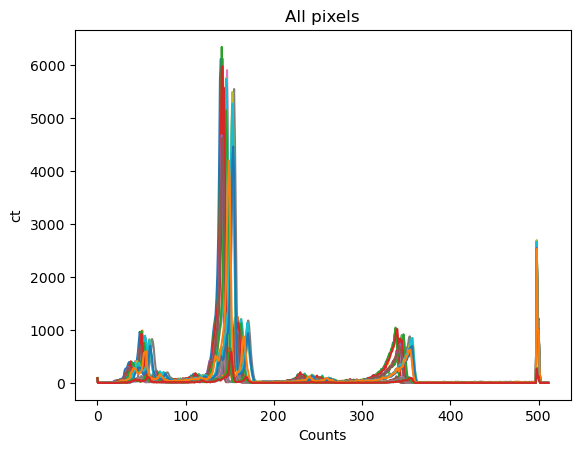

In [19]:
fig, ax = plt.subplots()
for this_index in range(24):
    this_spec = spec_list.spectrum(pixel_index=this_index)
    ax.plot(this_spec.spectral_axis, this_spec.flux)
plt.title("All pixels")
plt.xlabel("Counts")

Text(0.5, 1.0, 'Det0Pixel0L')

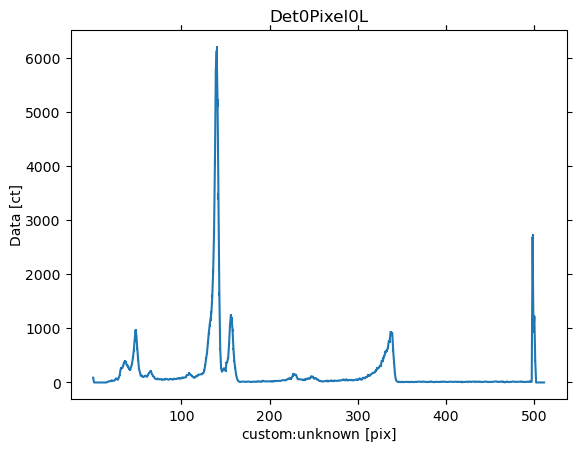

In [20]:
spec_list.spectrum(pixel_index=0).plot()
plt.title(spec_list.pixel_list[0]['label'])

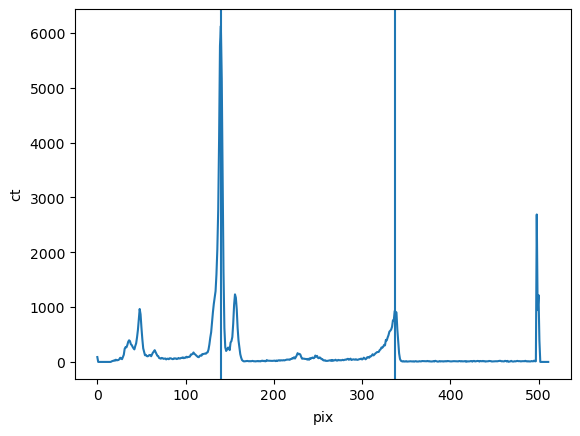

In [21]:
this_spec = spec_list.spectrum(pixel_index=0)
f = cal.get_calfunc_barium_rough(this_spec, plot=True)


In [22]:
lin_cal_params = cal.calibrate_speclist_barium_linear(spec_list)


In [23]:
lin_cal_params.shape

(24, 2)

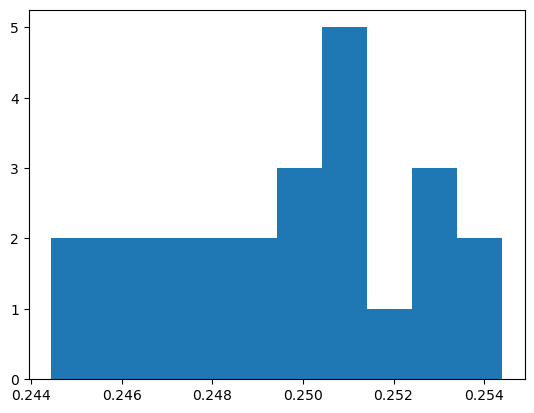

In [24]:
plt.hist(lin_cal_params[:, 0]);


In [25]:
cal_spec_list = cal.calibrate_linear_speclist(spec_list, lin_cal_params)

In [26]:
ba_line_energies = [7.8, 11.8, 30.85, 35, 53.5, 57.8, 81] * u.keV

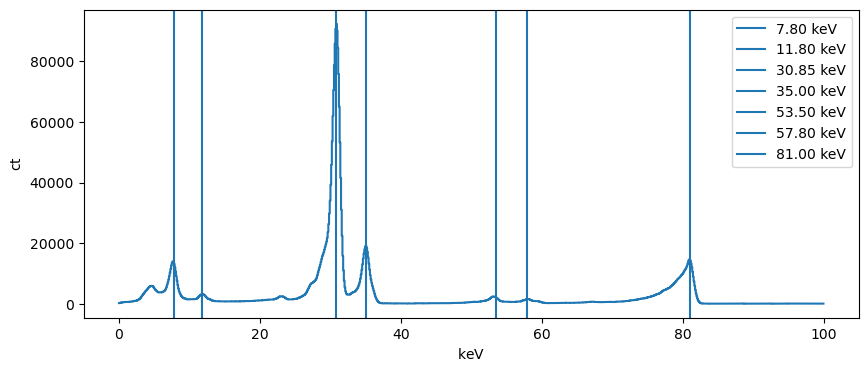

In [27]:
fig, ax = plt.subplots(figsize=(10, 4))
this_spec = cal_spec_list.spectrum(pixel_index=np.arange(24))
ax.step(this_spec.spectral_axis, this_spec.flux)
for this_energy in ba_line_energies:
    ax.axvline(this_energy, label=f"{this_energy:0.2f}")
plt.legend()

In [28]:
from specutils import SpectralRegion
sr = SpectralRegion([[5, 15], [15, 20], [20, 30]] * u.keV)
ts = cal_spec_list.lightcurve(pixel_index=0, sr=sr)

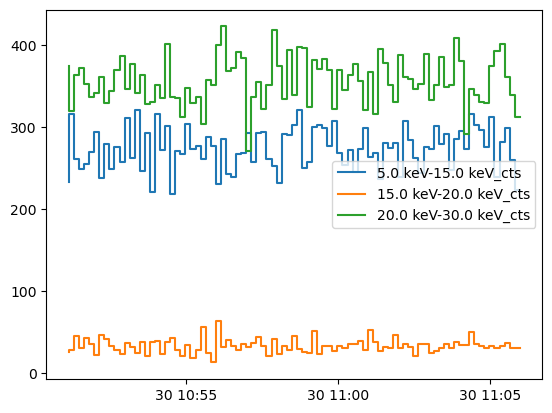

In [29]:
plt.step(ts.time.to_datetime(), ts[ts.colnames[1]], label=ts.colnames[1])
plt.step(ts.time.to_datetime(), ts[ts.colnames[2]], label=ts.colnames[2])
plt.step(ts.time.to_datetime(), ts[ts.colnames[3]], label=ts.colnames[3])
plt.legend()

In [30]:
from specutils import SpectralRegion
sr = SpectralRegion([[5, 15], [15, 20], [20, 30]] * u.keV)
ts = cal_spec_list.lightcurve(pixel_index=np.arange(24), sr=sr)

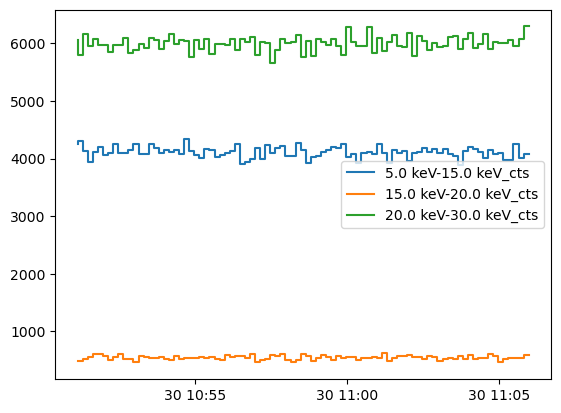

In [31]:
plt.step(ts.time.to_datetime(), ts[ts.colnames[1]], label=ts.colnames[1])
plt.step(ts.time.to_datetime(), ts[ts.colnames[2]], label=ts.colnames[2])
plt.step(ts.time.to_datetime(), ts[ts.colnames[3]], label=ts.colnames[3])
plt.legend()

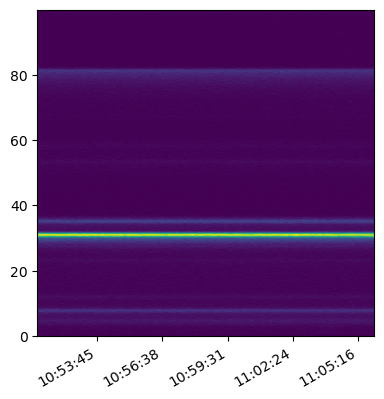

In [41]:
cal_spec_list.plot_spectrogram(aspect=0.0001)

## Americium data

In [33]:
am_lines = [13.9, 17.8, 20.8, 26.4, 59.5] * u.keV

In [34]:
am_spec_list = read_file(am_spec_file)


In [35]:
am_spec_list

SpectrumList (1,092 spectra, 2,852,338 events)
2025-01-30 12:17:50.641 - 15:19:40.641 (3hr 1min 50.0s)
<Spectrum1D(flux=[[[0.9835632625 ... 0.0]]] ct (shape=(1092, 24, 512), mean=0.21257 ct); spectral_axis=<SpectralAxis [  0.   1.   2. ... 509. 510. 511.] pix> (length=512))>

In [36]:
cal_am_spec_list = cal.calibrate_linear_speclist(am_spec_list, lin_cal_params)

Unfrotumately this approach does not scale for large numbers of spectra.

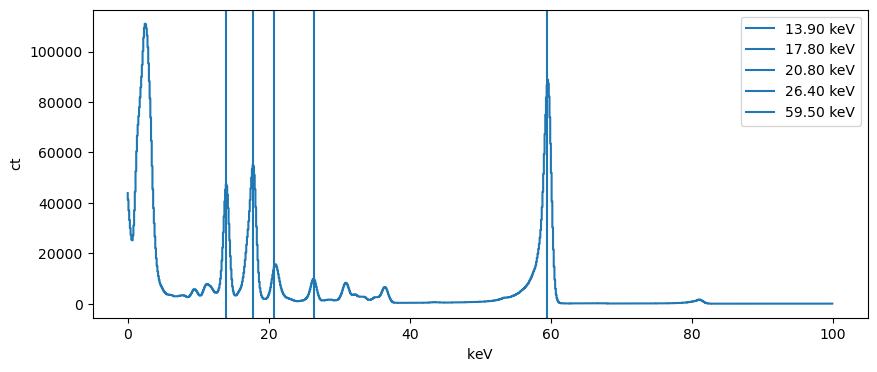

In [37]:
fig, ax = plt.subplots(figsize=(10, 4))
this_spec = cal_am_spec_list.spectrum(pixel_index=np.arange(24))
ax.step(this_spec.spectral_axis, this_spec.flux)
for this_energy in am_lines:
    ax.axvline(this_energy, label=f"{this_energy:0.2f}")
plt.legend()


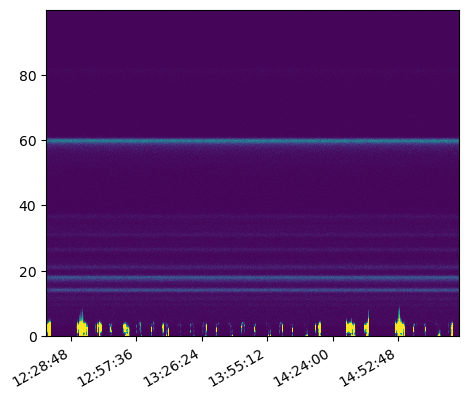

In [38]:
cal_am_spec_list.plot_spectrogram(aspect=0.001, vmax=200)